#### Run Analysis on Mobility Employment #### 

Unpickling warning: could not import behaviour.regional_behaviour_model.RegionalBehaviourModel: No module named 'behaviour'
Unpickling warning: could not import behaviour.behaviour_model.BehaviourModel: No module named 'behaviour'
Warning, the following errors were encountered during unpickling:

Failure 1 of 2:
Module: behaviour.regional_behaviour_model
Class: RegionalBehaviourModel
Error: No module named 'behaviour'

Failure 2 of 2:
Module: behaviour.behaviour_model
Class: BehaviourModel
Error: No module named 'behaviour'


Unable to load
    /home/andrew/dev/wble_proj/behaviour_module/tests/mobility_workers_debug.pop
as a gzipped pickle file. Loading pickles can fail if Python modules have changed
since the object was saved. If you are loading a custom class that has failed,
you can use the remapping argument; see the sc.loadobj() docstring for details.
Otherwise, you might need to revert to the previous version of that module (e.g.
in a virtual environment), save in a format other 

#### Prototype an algorithm for distributing smartwatches. ####

In [38]:
p_w = 0.3

p_w_given_i = [
0.1469311841,
0.1498439126,
0.2951441578,
0.2712238148,
0.4112715417,
]

# Less than. 
inc_bracs = [
20,
35,
50,
75,
300
]


p_w_given_a = [
0, # Set a zero probability for children, since we have no data. 
0.3808812547,
0.3516981132,
0.257718557,
0.1910219675,
0.1459854015
]

# Less than. 
age_bracs = [
18,
34,
49,
64,
74,
129
]

inc_bracs = [i*1000 for i in inc_bracs]

In [3]:

def rescale_2d_pmf(row_bracs, col_bracs, pmf, targ_row_bracs, targ_col_bracs):
    """
    Requires that the input PMF is coarser than the target PMF. 
    """
    # Make sure that targ_ages, targ_incs, are numpy arrays. 
    targ_row_bracs = np.array(targ_row_bracs)
    targ_col_bracs = np.array(targ_col_bracs)

    # Make sure that all original bracket values are contained in the new axes. 
    # ensure all values of census_income_bracs are in targ_col_bracs. 
    for i in row_bracs:
        if i not in targ_row_bracs:
            raise ValueError("Value {} not in targ_row_bracs".format(i))
    for i in col_bracs:
        if i not in targ_col_bracs:
            raise ValueError("Value {} not in targ_col_bracs".format(i))

    # Create a new array called A_I_joint_scaled of the target axes. 
    A_I_joint_scaled = np.zeros((len(targ_row_bracs), len(targ_col_bracs)))

    for i_age in range(pmf.shape[0]):
        for i_inc in range(pmf.shape[1]):
            # Get the current value. 
            cur_val = pmf[i_age, i_inc]
            # Get the previous income value. Set to 0 if first.
            prev_inc = 0 if i_inc == 0 else col_bracs[i_inc-1]
            prev_age = 0 if i_age == 0 else row_bracs[i_age-1]
            # Get the corresponding block of points in the new array.
            n_arr_age_start = np.argmax(targ_row_bracs >= prev_age) # new array age start
            # If you're on the last row, set the end to the end of the array.
            n_arr_age_end = len(targ_row_bracs) if i_age == pmf.shape[0]-1 else np.argmax(targ_row_bracs >= row_bracs[i_age])
            
            n_arr_inc_start = np.argmax(targ_col_bracs >= prev_inc)
            # If you're on the last column, just include the rest of the incomes. 
            n_arr_inc_end = len(targ_col_bracs) if i_inc == pmf.shape[1]-1 else np.argmax(targ_col_bracs >= col_bracs[i_inc])
            # Get the area of this block
            area = (n_arr_age_end - n_arr_age_start) * (n_arr_inc_end - n_arr_inc_start)
            # Scale the value by the area.
            A_I_joint_scaled[n_arr_age_start:n_arr_age_end, n_arr_inc_start:n_arr_inc_end] = cur_val / area
    return A_I_joint_scaled/np.sum(A_I_joint_scaled, axis=(0,1))


In [4]:
##### Get P(A,I) joint distribution. #####

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the tabular data
fpath = "/home/andrew/dev/wble_proj/behaviour_module/new_data/Canada"
fname = "/canada_hhinc_by_age.csv"
canada_data = pd.read_csv(fpath+fname)
# Drop the first column (age) and add it to a list. 
canada_data.drop(canada_data.columns[0], axis=1, inplace=True)
# Get a 2d array of the values
canada_data_array = canada_data.values

# Use bracket maximums
census_income_bracs = [10,15,20,25,30,35,40,45,50,60,70,75,80,90,100,150,200,250,300]
census_income_bracs = [i*1000 for i in census_income_bracs]
census_age_bracs = [24, 34, 44, 54, 64, 129] # TODO: See whether this is fine to do. (Treating probability from 64 to 130 all the same)

targ_inc_range = (0, 300000)
target_age_range = (0, 129)
targ_incs = np.linspace(targ_inc_range[0], targ_inc_range[1], num=301) # Results in 2k increments. 
targ_ages = np.linspace(target_age_range[0], target_age_range[1], num=130)


A_I_joint = rescale_2d_pmf(census_age_bracs, census_income_bracs, canada_data_array, targ_ages, targ_incs)

In [7]:
# Make some samples 
age_mesh, income_mesh = np.meshgrid(np.arange(len(targ_ages)), np.arange(len(targ_incs)))
# Convert to a list of tuples. 
age_income_tuples = list(zip(age_mesh.flatten(), income_mesh.flatten()))
# Flatten the joint distribution such that it's compatible with the mesh. 
A_I_joint_flat = A_I_joint.flatten(order='F')

# Draw 1000 samples from A_I_joint_flat. (Note we're drawing indicies, non-inclusive of the last value. )
i_samples = np.random.choice(len(age_income_tuples), size=100000, p=A_I_joint_flat)


In [12]:
len(age_income_tuples) == len(targ_ages)*len(targ_incs)

True

In [13]:
# Add all your people to a dict of dicts. TODO: make sure to do this in a random way in covasim. 
ppl_income_age = {}
for i in range(len(inc_bracs)):
    ppl_income_age[i] = {i:[] for i in range(len(age_bracs))} # Each cell contains a list of people we'll append to. 

for uid in i_samples:
    i_income = int(age_income_tuples[uid][1])
    i_age = int(age_income_tuples[uid][0])
    person = age_income_tuples[uid]

    # Get brackets. 
    income = targ_incs[i_income]
    age = targ_ages[i_age]

    # See which bracket the income calls into. 
    b_i = None
    for i, b_inc in enumerate(inc_bracs):
        if income < b_inc:
            b_i = i
            break
    # If still not assigned, assign to last bracket. 
    if b_i is None:
        b_i = len(inc_bracs) - 1
    
    # same for age.
    b_a = None
    for i, b_age in enumerate(age_bracs):
        if age < b_age:
            b_a = i
            break
    if b_a is None:
        b_a = len(age_bracs) - 1

    ppl_income_age[b_i][b_a].append(person)


In [14]:
# Get the totals for each axis. 
totals_income = {i:0 for i in range(len(inc_bracs))}
totals_age = {i:0 for i in range(len(age_bracs))}
# For each income bracket, get the total number of people in that bracket.
for i in range(len(inc_bracs)):
    for j in range(len(age_bracs)):
        totals_income[i] += len(ppl_income_age[i][j])

for i in range(len(age_bracs)):
    for j in range(len(inc_bracs)):
        totals_age[i] += len(ppl_income_age[j][i])

print(totals_income)
print(totals_age)

{0: 10256, 1: 16353, 2: 16596, 3: 23776, 4: 33019}
{0: 1413, 1: 14917, 2: 37431, 3: 27948, 4: 2824, 5: 15467}


In [19]:
# Calculate the number of watches to distribute for each age group. 
to_distribute_by_age = {i: int(totals_age[i]*p_w_given_a[i]) for i in range(len(age_bracs))}
to_distribute_by_inc = {i: int(totals_income[i]*p_w_given_i[i]) for i in range(len(inc_bracs))}

print(to_distribute_by_inc)
print(to_distribute_by_age)
# Print the sums. 
print("Sum for income: {}, sum for age: {}".format(sum(to_distribute_by_inc.values()), sum(to_distribute_by_age.values())))

{0: 1506, 1: 2450, 2: 4898, 3: 6448, 4: 13579}
{0: 0, 1: 5681, 2: 13164, 3: 7202, 4: 539, 5: 2257}
Sum for income: 28881, sum for age: 28843


In [27]:
to_distribute_by_age = {i: int(totals_age[i]*p_w_given_a[i]) for i in range(len(age_bracs))}
to_distribute_by_inc = {i: int(totals_income[i]*p_w_given_i[i]) for i in range(len(inc_bracs))}

# Track # watches distributed for each income and age. 
counts_emp_income_age = {}
for i in range(len(inc_bracs)):
    counts_emp_income_age[i] = {j:0 for j in range(len(age_bracs))} # Each cell contains a list of people we'll append to. 

# make copy of the ppl_income_age. 
ppl_income_age_copy = ppl_income_age.copy()

for i_brac in to_distribute_by_inc:
    i_count = to_distribute_by_inc[i_brac]
    for i in range(i_count):
        alloc = False
        while not alloc:
            # Draw an age based on to_distribute_by_age. 
            # If there's no uid in that age group, draw again.
            if sum(to_distribute_by_age.values()) == 0:
                a_brac = np.random.choice(len(age_bracs)) # If to_dist_by_age is 0, uniformly distribute to any age group.
            else:
                counts_dist = np.array(list(to_distribute_by_age.values()))
                p = counts_dist/np.sum(counts_dist)
                a_brac = np.random.choice(np.arange(len(age_bracs)), p=p)

            if len(ppl_income_age_copy[i_brac][a_brac]) > 0:
                ppl_income_age_copy[i_brac][a_brac].pop() # Remove last element. (Doesn't matter)
                alloc = True
                to_distribute_by_inc[i_brac] -= 1
                to_distribute_by_age[a_brac] -= 1 
                counts_emp_income_age[i_brac][a_brac] += 1


In [40]:
# Check empirical vs actual P(W|I) and P(W|A). 
counts_w_given_i = {i:0 for i in range(len(inc_bracs))}
for i in range(len(inc_bracs)):
    for j in range(len(age_bracs)):
        counts_w_given_i[i] += counts_emp_income_age[i][j]

counts_w_given_a = {i:0 for i in range(len(age_bracs))}
for i in range(len(age_bracs)):
    for j in range(len(inc_bracs)):
        counts_w_given_a[i] += counts_emp_income_age[j][i]

# Convert these to lists.
counts_w_given_i = np.array(list(counts_w_given_i.values()))
counts_w_given_a = np.array(list(counts_w_given_a.values()))


# Convert these to distributions. Get rid of any 0s in totals_income and totals_age. 
p_w_given_i_emp = counts_w_given_i/np.array(list(totals_income.values()))
p_w_given_a_emp = counts_w_given_a/np.array(list(totals_age.values()))

# In addition, count the total number of watches distributed. 
total_watches = sum(counts_w_given_i)


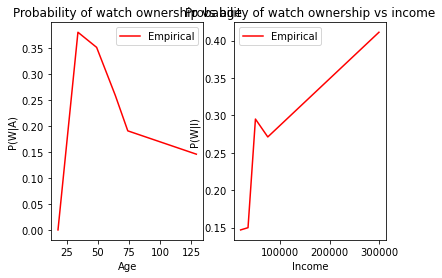

Ratio of People With Watches:  0.28881


In [42]:
"""
Results: 
The marginals are fit to almost perfectly. 
The sacrifice is the ratio of people with watches.
"""
# On two subplots, plot empirical P(W|A) and P(W|I) against the theoretical ones.
fig, axs = plt.subplots(1, 2)
axs[0].plot(age_bracs, p_w_given_a_emp, 'r', label='Empirical')
# axs[0].plot(age_bracs, p_w_given_a, 'g', label='Given')
axs[0].set_xlabel('Age')
axs[0].set_ylabel('P(W|A)')
axs[0].set_title('Probability of watch ownership vs age')
axs[0].legend()
axs[1].plot(inc_bracs, p_w_given_i_emp, 'r', label='Empirical')
# axs[1].plot(inc_bracs, p_w_given_i, 'g', label='Given')
axs[1].set_xlabel('Income')
axs[1].set_ylabel('P(W|I)')
axs[1].set_title('Probability of watch ownership vs income')
axs[1].legend()
plt.show()

print("Ratio of People With Watches: ", total_watches/100000)

In [43]:
print(p_w_given_i_emp)
print(p_w_given_i)

[0.14684087 0.1498196  0.29513136 0.27119785 0.41124807]
[0.1469311841, 0.1498439126, 0.2951441578, 0.2712238148, 0.4112715417]


#### Look at Synthpops Parameters ####

In [167]:
# import the data jsons. 
import json
import os
data_dir = "/home/andrew/dev/wble_proj/behaviour_module/behaviour/data"

# load the json file for canada. 
with open(os.path.join(data_dir, "canada.json")) as f:
    canada_data = json.load(f)

# load for usa-Washington. 
with open(os.path.join(data_dir, "usa-Washington.json")) as f:
    usa_washington_data = json.load(f)

# see what keys are in usa_washington_data but not in  canada_data.
for key in usa_washington_data.keys():
    if key not in canada_data.keys():
        print(key)

# load for usa. 
with open(os.path.join(data_dir, "usa.json")) as f:
    usa_data = json.load(f)

# See what keys in in usa but not in canada_data. 
for key in usa_data.keys():
    if key not in canada_data.keys():
        print(key)

#### Income Distribution: Create a CDF and sample ####

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [161]:
fpath = "/home/andrew/dev/wble_proj/behaviour_module/new_data/Canada"
fname = "/canada_hhinc_by_age.csv"
canada_data_brackets = pd.read_csv(fpath+fname)
canada_age_brackets

0        0 to 24 years
1       25 to 34 years
2       35 to 44 years
3       45 to 54 years
4       55 to 64 years
5    65 years and over
Name: Unnamed: 0, dtype: object

In [24]:
# Load the tabular data
fpath = "/home/andrew/dev/wble_proj/behaviour_module/new_data/Canada"
fname = "/canada_hhinc_by_age.csv"
canada_data = pd.read_csv(fpath+fname)

# Extract the values of the first column (age brackets)
canada_age_brackets = canada_data.iloc[:,0]

# Drop the first column (age) and add it to a list. 
canada_data.drop(canada_data.columns[0], axis=1, inplace=True)

# Get the income brackets
canada_data_columns = canada_data.columns.values

# Get a 2d array of the values
canada_data_array = canada_data.values

canada_ages = []

In [115]:
canada_age_brackets

0        0 to 24 years
1       25 to 34 years
2       35 to 44 years
3       45 to 54 years
4       55 to 64 years
5    65 years and over
Name: Unnamed: 0, dtype: object

In [80]:

incomes = [10,15,20,25,30,35,40,45,50,60,70,75,80,90,100,150,200,250,350]
for i, j in zip(canada_data.columns, incomes): # Match em up. 
    print(i, j)
    
assert len(incomes) == len(canada_data.columns)

Under $10,000 10
$10,000 and over 15
$15,000 and over 20
$20,000 and over 25
$25,000 and over 30
$30,000 and over 35
$35,000 and over 40
$40,000 and over 45
$45,000 and over 50
$50,000 and over 60
$60,000 and over 70
$70,000 and over 75
$75,000 and over 80
$80,000 and over 90
$90,000 and over 100
$100,000 and over 150
$150,000 and over 200
$200,000 and over 250
$250,000 and over 350


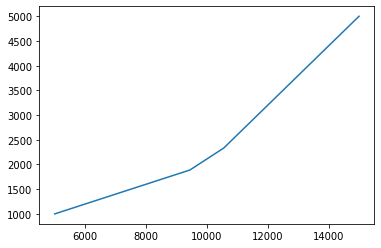

In [62]:
# Interpolate an array to bins_out different values. 
# Example: Begin with [1,3,5]
# interpolate_array(a, bins_out=5) -> [1, 2, 3, 4, 5]
def interpolate(x_axis, y_axis, vals_to_interp_to):
    xaxis_new = np.linspace(min(x_axis), max(x_axis), vals_to_interp_to)
    pdf_counts_interp = np.interp(xaxis_new, x_axis, y_axis)
    return xaxis_new, pdf_counts_interp
    
incomes = [5000, 10000, 15000]
pdf_counts = [1000, 2000, 5000]
a, b = interpolate(incomes, pdf_counts, 10)
plt.plot(a,b)

In [127]:
a = np.array([0, 1, 2, 3, 4, 5, 6])
b = np.array([0, 5, 5, 6, 7])
# Get start and ending points in a corresponding to first gap in b. 
a_start = np.argmax(a >= b[0])
a_end = np.argmax(a >= b[1])
print(a[a_start:a_end]) # array slicing doesn't include the last index. 

[0 1 2 3 4]


In [164]:
# Make sure I understand flattening. 
# init a 2D array which increments by one. 
a = np.arange(0, 10).reshape(2, 5)
print(a)
a.flatten(order='F')

[[0 1 2 3 4]
 [5 6 7 8 9]]


array([0, 5, 1, 6, 2, 7, 3, 8, 4, 9])

Verification: 0.9999999999999999
Verify conditional: 1.0
Verify conditional: 1.0
Verify conditional: 1.0
Verify conditional: 0.9999999999999999
Verify conditional: 1.0
Verify conditional: 1.0


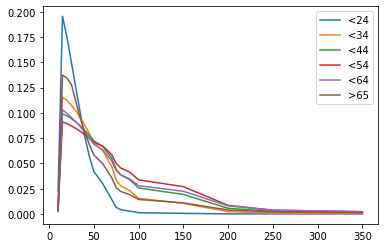

In [105]:
# Make a normalized version of this array such that the entire array sums to 1
canada_data_array_norm = canada_data_array / canada_data_array.sum(axis=(0,1))
print("Verification: {}".format(np.sum(canada_data_array_norm, axis=(0,1))))

# get the marginals over this distribution. 
p_age = canada_data_array_norm.sum(axis=1)
p_income = canada_data_array_norm.sum(axis=0)

# plt.plot(p_age)
# Get corresponding row of the joint distribution. 
cur_age_bracket = 2
cur_joint = canada_data_array_norm[cur_age_bracket,:]

# Make interpolated pdf for age.
p_As = canada_data_array.sum(axis=1)
p_As = p_As/np.sum(p_As) # Normalize to a pdf. 

num_ages = canada_data_array.shape[0]
num_incomes = canada_data_array.shape[1]

# Load all values into a table. 
all_cond_probs = np.zeros((num_ages, num_incomes))

for b_hh_age in range(6): 
    p_A = p_As[b_hh_age]

    cur_joint = canada_data_array_norm[b_hh_age,:] # incomes for the current household age bracket 

    p_I_given_A = cur_joint/p_A
    all_cond_probs[b_hh_age,:] = p_I_given_A
    
    print("Verify conditional: {}".format(np.sum(p_I_given_A)))

    plt.plot(incomes, p_I_given_A)

age_brackets = ["<24", "<34", "<44", "<54", "<64", ">65"]
plt.legend(age_brackets)

plt.show()

(array([55863., 31419.,  9866.,     0.,  1914.,   537.,     0.,   261.,
            0.,   140.]),
 array([ 10.,  44.,  78., 112., 146., 180., 214., 248., 282., 316., 350.]),
 <a list of 10 Patch objects>)

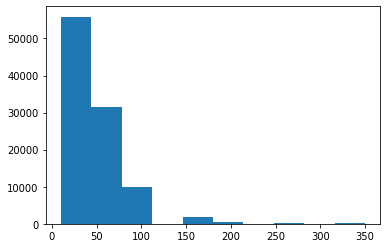

In [107]:
# Now sample from the conditionals. Fix age bracket, sample 1000 times, and see if we replicate the distribution. 
cur_age_bracket = 2
cur_cond = all_cond_probs[cur_age_bracket,:]
cur_incomes = []
for i in range(100000):
    cur_income = np.random.choice(incomes, p=cur_cond)
    cur_incomes.append(cur_income)

# make a histogram
plt.hist(cur_incomes, bins=10)

# note that this is ok; some of the values are zero simply because the incomes are not evenly distributed. 

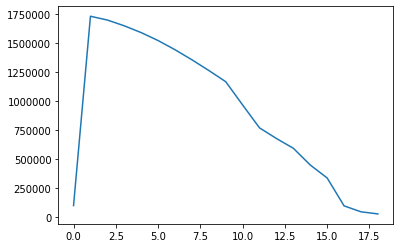

In [139]:
# Plot the 4th row of canada_data. 
plt.plot(canada_data_array[2,:])
# canada_data

In [141]:
canada_data

,"Under $10,000","$10,000 and over","$15,000 and over","$20,000 and over","$25,000 and over","$30,000 and over","$35,000 and over","$40,000 and over","$45,000 and over","$50,000 and over","$60,000 and over","$70,000 and over","$75,000 and over","$80,000 and over","$90,000 and over","$100,000 and over","$150,000 and over","$200,000 and over","$250,000 and over"
0,13990,124360,111140,95090,78900,63030,48380,36130,26660,19030,9090,4090,2700,1790,790,370,50,30,20
1,52970,975390,947850,907420,860250,804550,740010,670510,599270,528490,395820,282190,235160,194030,130680,88190,18950,7580,4090
2,100190,1733540,1700770,1650990,1592440,1524000,1444930,1358040,1265600,1168980,968140,770390,678980,594580,450240,338130,97800,46590,28400
3,72750,1633460,1602520,1560020,1514000,1462480,1403820,1340740,1273360,1202670,1051660,894140,816670,742240,604340,484220,152050,66930,39760
4,41650,1086970,1050080,1006310,961400,909380,850530,789940,728690,668620,554900,453420,408040,366450,295280,237080,84100,39270,23660
5,21940,1261130,1233220,1173490,1015190,864490,739080,630890,536440,455120,328000,238290,204000,175330,131470,100490,35690,18560,11730


#### Income Distribution: Load Canada's Data ####

In [142]:
# Process the data first.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [143]:
# Read the data.
fpath = "/home/andrew/Downloads/canada_hhinc_by_age/canada_hhinc_by_age.csv"
df = pd.read_csv(fpath)
# Get entries with family type = "couple families" and geo == Canada.
df = df[(df["Family type"] == "Couple families") & (df["GEO"] == "Canada")]
df.size

/home/andrew/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (13,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


49980

In [144]:
# drop rows where "age of older adult" = total all ages
df = df[df["Age of older adult"] != "Total all ages"]
# drop rows where "Family income" == "Median total income" or "Total all income groups"
df = df[df["Family income"] != "Median total income"]
df = df[df["Family income"] != "Total all income groups"]

# get name of each "Age of older adult" column. 
age_cols = df["Age of older adult"].unique()
# get name of each "Family income" column.
income_cols = df["Family income"].unique()
# # get a table of age_cols vs income_cols with VALUE as the value.
df_table = pd.DataFrame(index=age_cols, columns=income_cols)
# fill the table with the corresponding values from df.VALUE.
for age in age_cols:
    for income in income_cols:
        df_table.loc[age, income] = df[(df["Age of older adult"] == age) & (df["Family income"] == income)]["VALUE"].values[0]

df_table

,"Under $10,000","$10,000 and over","$15,000 and over","$20,000 and over","$25,000 and over","$30,000 and over","$35,000 and over","$40,000 and over","$45,000 and over","$50,000 and over","$60,000 and over","$70,000 and over","$75,000 and over","$80,000 and over","$90,000 and over","$100,000 and over","$150,000 and over","$200,000 and over","$250,000 and over"
0 to 24 years,13990,124360,111140,95090,78900,63030,48380,36130,26660,19030,9090,4090,2700,1790,790,370,50,30,20
25 to 34 years,52970,975390,947850,907420,860250,804550,740010,670510,599270,528490,395820,282190,235160,194030,130680,88190,18950,7580,4090
35 to 44 years,100190,1733540,1700770,1650990,1592440,1524000,1444930,1358040,1265600,1168980,968140,770390,678980,594580,450240,338130,97800,46590,28400
45 to 54 years,72750,1633460,1602520,1560020,1514000,1462480,1403820,1340740,1273360,1202670,1051660,894140,816670,742240,604340,484220,152050,66930,39760
55 to 64 years,41650,1086970,1050080,1006310,961400,909380,850530,789940,728690,668620,554900,453420,408040,366450,295280,237080,84100,39270,23660
65 years and over,21940,1261130,1233220,1173490,1015190,864490,739080,630890,536440,455120,328000,238290,204000,175330,131470,100490,35690,18560,11730


In [162]:
# Convert df_table into brackets. Ex: columns are (0 to 10k, 10k to 15k, ..., 250k to 300k). 
census_income_bracs = [10,15,20,25,30,35,40,45,50,60,70,75,80,90,100,150,200,250,300]

canada_data_brackets = pd.DataFrame(index=age_cols, 
    columns=census_income_bracs, 
    data=np.zeros((len(age_cols), len(census_income_bracs))))

# Set the first column of canada_data_brackets to that of df_table.
canada_data_brackets.iloc[:,0] = df_table.iloc[:,0]
# Same for the last column
canada_data_brackets.iloc[:,-1] = df_table.iloc[:,-1]

# for each other column in canada_data_brackets, calculate the number of people in the brackets.  
for i in range(1, len(census_income_bracs)-1):
    canada_data_brackets.iloc[:,i] = df_table.iloc[:,i] - df_table.iloc[:,i+1]

canada_data_brackets

,10,15,20,25,30,35,40,45,50,60,70,75,80,90,100,150,200,250,300
0 to 24 years,13990,13220,16050,16190,15870,14650,12250,9470,7630,9940,5000,1390,910,1000,420,320,20,10,20
25 to 34 years,52970,27540,40430,47170,55700,64540,69500,71240,70780,132670,113630,47030,41130,63350,42490,69240,11370,3490,4090
35 to 44 years,100190,32770,49780,58550,68440,79070,86890,92440,96620,200840,197750,91410,84400,144340,112110,240330,51210,18190,28400
45 to 54 years,72750,30940,42500,46020,51520,58660,63080,67380,70690,151010,157520,77470,74430,137900,120120,332170,85120,27170,39760
55 to 64 years,41650,36890,43770,44910,52020,58850,60590,61250,60070,113720,101480,45380,41590,71170,58200,152980,44830,15610,23660
65 years and over,21940,27910,59730,158300,150700,125410,108190,94450,81320,127120,89710,34290,28670,43860,30980,64800,17130,6830,11730


In [163]:
save_path = "/home/andrew/dev/wble_proj/behaviour_module/new_data/Canada"
# make the directory if it doesn't exist yet
import os
if not os.path.exists(save_path):
    os.makedirs(save_path)

# Save the table, including the index and column names.
canada_data_brackets.to_csv(save_path + "/canada_hhinc_by_age.csv")


#### Multi-region Worker-Mixing Test ####

In [1]:
import numpy as np
from behaviour import RegionalBehaviourModel

"""
Warning: hard-coded. Will break if you change the params. 
"""
params_ca = dict(name = 'toronto', n=20000, com_contacts=20) # large city
params_cb = dict(name = 'miss', n=10000, com_contacts=10) # medium city
params_cc = dict(name = 'milton', n=5000,  com_contacts=10) # small city

dests_a = {'miss':0.6, 'milton':0.4}
dests_b = {'toronto':0.9, 'milton':0.1}
dests_c = {'toronto':0.9, 'miss': 0.1}

params_work_mixing = dict(toronto = {"leaving":0.05, "dests":dests_a},
                          miss =    {"leaving":0.4, "dests":dests_b},
                          milton =  {"leaving":0.3, "dests":dests_c})

pop_mod = RegionalBehaviourModel(None, params_work_mixing, *(params_ca, params_cb, params_cc))


Covasim 3.1.2 (2022-01-16) — © 2020-2022 by IDM
Community mixing parameters not given; initializing defaults...
BEHAVIOUR_MODULE
BEHAVIOUR_MODULE
BEHAVIOUR_MODULE


In [4]:
pop_mod.regs['toronto'].structs.keys()

['age_by_uid',
 'fam_income_by_uid',
 'homes_by_uids',
 'homes_by_ages',
 'student_uid_lists',
 'student_age_lists',
 'facilities',
 'facilities_uid_lists',
 'school_type_by_age',
 'school_mixing_types',
 'school_types',
 'workplaces_by_industry_codes',
 'teacher_uid_lists',
 'non_teaching_staff_uid_lists',
 'workplace_uid_lists',
 'facilities_staff_uid_lists']

In [3]:
firms = pop_mod.regs['toronto'].structs.workplace_uid_lists
n_from_a = {}
n_from_b = {}
n_from_c = {}
for reg in pop_mod.regs:
    firms = pop_mod.regs[reg].structs.workplace_uid_lists
    n_from_a[reg] = []
    n_from_b[reg] = []
    n_from_c[reg] = []
    
    for firm in firms:
        n_from_a[reg].append(sum([i < 20000 for i in firm])) # identify origin of the agents based on their uid
        n_from_b[reg].append(sum([i >= 20000 and i < 30000 for i in firm]))
        n_from_c[reg].append(sum([i >= 30000 for i in firm]))


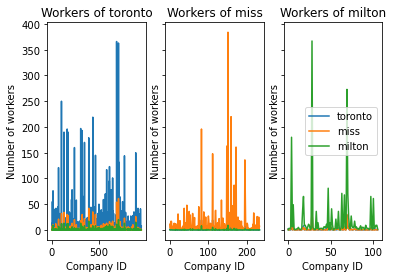

In [26]:
import matplotlib.pyplot as plt

# Create 3 subplots, for the 3 separate regions. 
fig, axs = plt.subplots(1,3,sharey=True)

regs = list(pop_mod.regs.keys())

for i_reg, reg in enumerate(pop_mod.regs):
    x_axis = np.arange(len(pop_mod.regs[reg].structs.workplace_uid_lists))
    axs[i_reg].plot(x_axis, n_from_a[reg])
    axs[i_reg].plot(x_axis, n_from_b[reg])
    axs[i_reg].plot(x_axis, n_from_c[reg])
    axs[i_reg].set_title(f"Workers of {reg}")
    axs[i_reg].set_xlabel("Company ID")
    axs[i_reg].set_ylabel("Number of workers")

plt.legend(regs)

plt.show()

In [30]:
#### Recreate the Matrix ####
# pop_mod.total_valid_workers["toronto"]

src_dest = {}
reg_list = list(pop_mod.regs.keys())

ranges = {"toronto":[0,20000], "miss": [20000,30000], "milton":[30000,35000]}
    
for src in pop_mod.regs:
    oregs = list(reg_list)
    oregs.remove(src)
    
    dest_counts = {oregs[0]:0, oregs[1]:0} # always only 2 other regs.

    for dest in oregs:
        # Count number of people from src city working in this other region. 
        wkplces = pop_mod.regs[dest].structs.workplace_uid_lists
        for wkplce in wkplces:
            for uid in wkplce:
                if uid > ranges[src][0] and uid < ranges[src][1]:
                    dest_counts[dest] += 1
        src_dest[src] = dest_counts
# go_to_come_from = {}
# reg_list = list(pop_mod.regs.keys())
# for dest in pop_mod.regs:
#     oregs = list(reg_list)
#     oregs.remove(dest)
    
#     ranges = {"toronto":[0,20000], "miss": [20000,30000], "milton":[30000,35000]}
#     src_counts = {oregs[0]:0, oregs[1]:0} # always only 2 other regs.
#     wkplces = pop_mod.regs[dest].structs.workplace_uid_lists
#     for workplace in wkplces:
#         for uid in workplace:
#             for oreg in oregs:
#                 if uid > ranges[oreg][0] and uid < ranges[oreg][1]:
#                     src_counts[oreg] += 1
                    
#     go_to_come_from[dest] = src_counts

# get total number of workers.
# recreate counts_goto_comefrom.
# some divison.

In [31]:
src_dest

{'toronto': {'miss': 250, 'milton': 175},
 'miss': {'toronto': 1640, 'milton': 181},
 'milton': {'toronto': 591, 'miss': 63}}

In [33]:
# Normalize the count matrix and calculate the number of people that left. 
# Results: Ratios are perfect. n_left has <20% error. Probably some details behind how they allocate workers.
n_left = {}
import sciris as sc

src_dest_normalized = sc.dcp(src_dest)
for src in src_dest:
    oregs = list(reg_list)
    oregs.remove(src)
    
    total_left = 0
    for dest in oregs:
        total_left += src_dest[src][dest]
    
    # Update entries with normalized values. 
    for dest in oregs:
        src_dest_normalized[src][dest] = src_dest[src][dest]/total_left
    
    n_left[src] = total_left/pop_mod.total_valid_workers[src]
    
print(src_dest_normalized)
print(n_left)

{'toronto': {'miss': 0.5882352941176471, 'milton': 0.4117647058823529}, 'miss': {'toronto': 0.900604063701263, 'milton': 0.09939593629873696}, 'milton': {'toronto': 0.9036697247706422, 'miss': 0.0963302752293578}}
{'toronto': 0.039213877099095774, 'miss': 0.33678564823377105, 'milton': 0.24707215715904798}


In [28]:
pop_mod.total_valid_workers["miss"]

5407

In [7]:
pop_mod.regs['toronto'].structs.keys()

['age_by_uid',
 'fam_income_by_uid',
 'homes_by_uids',
 'homes_by_ages',
 'student_uid_lists',
 'student_age_lists',
 'facilities',
 'facilities_uid_lists',
 'school_type_by_age',
 'school_mixing_types',
 'school_types',
 'workplaces_by_industry_codes',
 'teacher_uid_lists',
 'non_teaching_staff_uid_lists',
 'workplace_uid_lists',
 'facilities_staff_uid_lists']

#### Structures Test ####

In [9]:
import synthpops as sp
import numpy as np

In [41]:
pop = sp.Pop.load('population1.pop')
pop_mod = sp.Pop.load('population2.pop')

In [45]:
# Schools.
# Check if number of schools is equal.
assert len(pop.schools) == len(pop_mod.schools)

# Check if students, teachers, other staff are all equal. 
for i_school in range(len(pop.schools)):
    t_school = pop.schools[i_school] # t for truth
    m_school = pop_mod.schools[i_school] # m for modified
    assert np.array_equal(t_school['student_uids'], m_school['student_uids'])
    assert np.array_equal(t_school['teacher_uids'], m_school['teacher_uids'])
    assert np.array_equal(t_school['non_teaching_staff_uids'], m_school['non_teaching_staff_uids'])
    
# Workplaces
assert len(pop.workplaces) == len(pop_mod.workplaces)

for i_wp in range(len(pop.workplaces)):
    t_wp = pop.workplaces[i_wp]
    m_wp = pop_mod.workplaces[i_wp]
    assert np.array_equal(t_wp['member_uids'], m_wp['member_uids'])

# Homes
t_into_arr = np.array(pop.homes_by_uids, dtype='object')
m_into_arr = np.array(pop_mod.homes_by_uids, dtype='object')

assert np.array_equal(t_into_arr, m_into_arr)

In [43]:
pop.workplaces[0]

{'member_uids': array([12127, 16896,   708,  9200, 16419,  2882, 11806,  4973, 15606,
        14449,  7741,  8039,  2633, 10904, 17898, 14365,  2245,  7053,
         7914,   456,  2732, 17233,  8945]),
 'wpid': 0}

In [39]:
pop.homes_by_uids[0][2] = 0

#### Connections Test ####

In [1]:
import synthpops as sp
import numpy as np

In [13]:
pop_truth = sp.Pop.load('population_truth.pop')
pop_mod = sp.Pop.load('population_truth.pop')

In [14]:
# Surprisingly fast 
pop_truth = pop_truth.popdict
pop_mod = pop_mod.popdict

assert len(pop_truth) == len(pop_mod)

for uid in range(len(pop_truth)):
    for layer in ['H','S','W','C']:
        assert np.array_equal(pop_mod[uid]['contacts'][layer], pop_truth[uid]['contacts'][layer])

In [15]:
pop_truth

{0: {'age': 43,
  'sex': 1,
  'loc': None,
  'contacts': {'H': [1, 2, 3, 4],
   'S': [],
   'W': [8928, 5546, 6191, 7632, 659, 251, 7070],
   'C': [],
   'LTCF': []},
  'ltcf_res': None,
  'ltcf_staff': None,
  'hhid': 0,
  'scid': None,
  'sc_student': None,
  'sc_teacher': None,
  'sc_staff': None,
  'sc_type': None,
  'sc_mixing_type': None,
  'wpid': 142,
  'wpindcode': None,
  'ltcfid': None},
 1: {'age': 30,
  'sex': 0,
  'loc': None,
  'contacts': {'H': [0, 2, 3, 4],
   'S': [],
   'W': [7045,
    3462,
    6792,
    5901,
    2575,
    4885,
    3736,
    5415,
    3246,
    5940,
    3636,
    8390,
    1479,
    6471,
    6854,
    8775,
    2907,
    2796,
    3951],
   'C': [],
   'LTCF': []},
  'ltcf_res': None,
  'ltcf_staff': None,
  'hhid': 0,
  'scid': None,
  'sc_student': None,
  'sc_teacher': None,
  'sc_staff': None,
  'sc_type': None,
  'sc_mixing_type': None,
  'wpid': 65,
  'wpindcode': None,
  'ltcfid': None},
 2: {'age': 8,
  'sex': 1,
  'loc': None,
  'contac

#### Playing with kwargs ####

In [38]:
params_ca = dict(name = 'toronto', n=20000, com_contacts=20) # large city
params_cb = dict(name = 'miss', n=10000, com_contacts=10) # medium city
params_cc = dict(name = 'milton', n=5000,  com_contacts=10) # small city
all_params = dict(one = params_ca, two = params_cb, three = params_cc)


def multi_sim(mixing_pars, *foo):
    for item in foo:
        behaviour_model(**item)
    print(len(foo))
#     print(kwargs)
def behaviour_model(**foo):
    for key, item in foo.items():
        print("{}: {}".format(key, item))

# Interface: just pass as **kwargs rather than a whole dict, for more options.
multi_sim('foo', *(params_ca, params_cb, params_cc))


name: toronto
n: 20000
com_contacts: 20
name: miss
n: 10000
com_contacts: 10
name: milton
n: 5000
com_contacts: 10
3


In [20]:
params_ca = dict(name = 'toronto', n=20000, com_contacts=20) # large city
params_cb = dict(name = 'miss', n=10000, com_contacts=10) # medium city
params_cc = dict(name = 'milton', n=5000,  com_contacts=10) # small city
all_params = dict(one = params_ca, two = params_cb, three = params_cc)

**all_params

SyntaxError: invalid syntax (2070570882.py, line 6)

In [52]:
num_cities = 3
come_from_cur = 0.8
come_from_others = 0.2


ret = (come_from_others/(num_cities-1))* \
    np.ones((num_cities, num_cities))
for i in range(ret.shape[0]):
    ret[i][i] = come_from_cur

In [53]:
ret

array([[0.8, 0.1, 0.1],
       [0.1, 0.8, 0.1],
       [0.1, 0.1, 0.8]])

In [54]:
import sciris as sc

In [55]:
a = dict(name = 'toronto', n=20000, com_contacts=20)
b = sc.objdict(a)

In [57]:
b.pop('name')

'toronto'

In [58]:
b

#0. 'n':            20000
#1. 'com_contacts': 20

In [60]:
a.pop('name')

'toronto'

In [61]:
a

{'n': 20000, 'com_contacts': 20}